## Toy Models of Superposition -- paper replication

This notebook presents the results of the replication of the paper 'Toy Models of Superposition', Elhage et al.

### Section 2

We begin with Section 2, in which we want to understand whether models store features in superposition if there are more features than neurons (in the smallest layer of the model). As demonstrated in the paper, we will see that the toy models considered here do this if the features in the training data are sufficiently sparse.


In [1]:

import torch as t
import os

from typing import Union, Optional
from einops import rearrange, reduce, repeat
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import matplotlib as mlp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.pyplot import matshow

from training import generate_synthetic_data, train, ProjectAndRecover, load_models_section2, SPARSITIES
from visualization import plot_weights_and_bias, visualize_superposition

SMALL_MODELS_PATHNAME = "./model-weights/section2-small/"
BIG_MODELS_PATHNAME = "./model-weights/section2-big/"
SPARSITIES = [0., .7, .9, .97, .99, .997, .999]
device = 'cpu'

We consider a model of the following architecture:

The first layer is a linear transformation that projects a vector of dimension `input_dim` to a vector of dimension `hidden_dim`, i.e. it is multiplication with a matrix of shape (input_dim, hidden_dim). The second layer is given by the transpose of this matrix and recovers the input dimension. As activation function we take a ReLU.

We generate data where each feature (here given as the standard basis vectors) is zero with probability `sparsity` and uniformly distributed in $[0,1]$ otherwise.

Below we train one model on this data with respect to the loss function mean squared error, weighted by the vector `importance`.

In [2]:
input_dim = 20                   # 20 for small models / 80 for big models
hidden_dim = 5                   # 5 for small models / 20 for big models
importance_factor = .7           # .7 for small models / .9 for big models
importance = t.tensor([importance_factor ** i for i  in range(input_dim)])
    
sparsity = 0.9                   # or any float in [0,1)

size_trainingdata = 100000
data = generate_synthetic_data(input_dim, size_trainingdata, sparsity)

batch_size = 128
epochs = 20

trainloader = DataLoader(tuple((data)), batch_size= batch_size)
model = ProjectAndRecover(input_dim, hidden_dim, importance).to(device).train()
model = train(model, trainloader, epochs=epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, train loss is 0.0031979866325855255
Epoch 1, train loss is 0.0025589712895452976
Epoch 2, train loss is 0.0021834990475326777
Epoch 3, train loss is 0.0015874815871939063
Epoch 4, train loss is 0.0008951412746682763
Epoch 5, train loss is 0.0005111602367833257
Epoch 6, train loss is 0.00035190279595553875
Epoch 7, train loss is 0.0003027236962225288
Epoch 8, train loss is 0.00029197163530625403
Epoch 9, train loss is 0.00028756045503541827
Epoch 10, train loss is 0.0002850281016435474
Epoch 11, train loss is 0.0002831847523339093
Epoch 12, train loss is 0.0002823817194439471
Epoch 13, train loss is 0.00028225514688529074
Epoch 14, train loss is 0.00028224074048921466
Epoch 15, train loss is 0.0002822466485667974
Epoch 16, train loss is 0.0002822604146786034
Epoch 17, train loss is 0.000282274471828714
Epoch 18, train loss is 0.0002822842507157475
Epoch 19, train loss is 0.0002822869864758104


We visualize the resulting weight matrix $W^T W$, given by concatenating the first two layers, and the bias vector b. 

For `sparsity` = 0.0 we see that only the first `hidden_dim` features are represented, by the first column vectors which are the first standard basis vectors in this case. For larger sparsities we see that more and more features are represented. For `sparsity` = .7, the visualization indicates that a pair of two features is represented by one neuron. For different training runs the pairs differ.

You can train models of different sizes and for different sparsities. For the latter think on a log scale; changes in values close to 1 make a bigger difference. For bigger models and sparse features, it may be necessary to increase the size of the training data or the number of epochs.

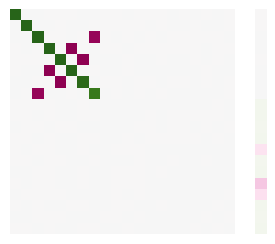

In [3]:
W = model.weights.data
b = model.bias.data
plot_weights_and_bias(W, b)

We compute the superposition metric as described in the paper and visualize it below. Each bar corresponds to one feature, represented by the i-th column $W_i$ of the weight matrix $W$.

The length of bar $i$ is given by the norm of $W_i$, which corresponds to how well the feature is represented. The color indicates if the feature is stored in a dedicated direction (dark blue) or in superposition with other features (yellow). We use the metric for superposition defined in the paper  
$\operatorname{superposition}(W_i) =\frac {1}{\| W_i \|}\sum_{i \neq j} W_i \cdot W_j$, i.e. the normalized sum of the dot products of $W_i$ with the other column vectors $W_j$. In other words, the metric is zero if the i-th column is orthogonal to the other columns; and non-zero if some dot product is non-trivial, i.e. the storage direction is "shared".

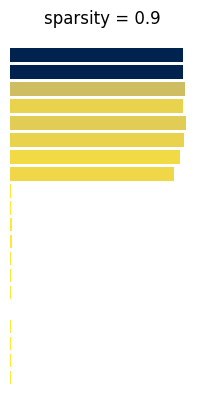

In [4]:
visualize_superposition(model.weights, sparsity)

We have trained and saved models for the sparsities $\{ 0.0, 0.7, 0.9, 0.97, 0.99, 0.997, 0.999\}$. They can be loaded and visualized using the cells below.


In [5]:
small_models = {}
load_models_section2(small_models)

big_models = {}
load_models_section2(big_models, big = True)

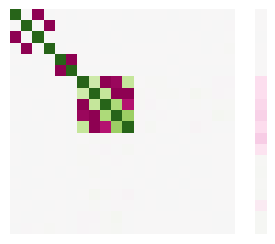

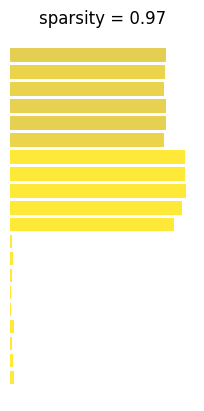

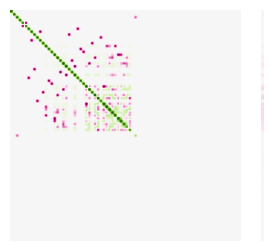

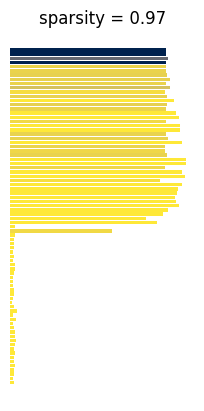

In [6]:

i = 3                                           # choose 0 <= i <= 6
small_model = small_models[SPARSITIES[i]] 
plot_weights_and_bias(small_model.weights.data, small_model.bias.data)
visualize_superposition(small_model.weights, SPARSITIES[i])
big_model = big_models[SPARSITIES[i]] 
plot_weights_and_bias(big_model.weights.data, big_model.bias.data)
visualize_superposition(big_model.weights, SPARSITIES[i])




And below an overview of these plots for all sparsity levels. 

Qualitatively, we obtain the same results as in Section 2 of the paper: With increasing sparsity more and more features are stored in superposition; first in pairs and then in groups. More important features keep their dedicated direction for longer. The visualizations for the larger model look similar though more stochastic.

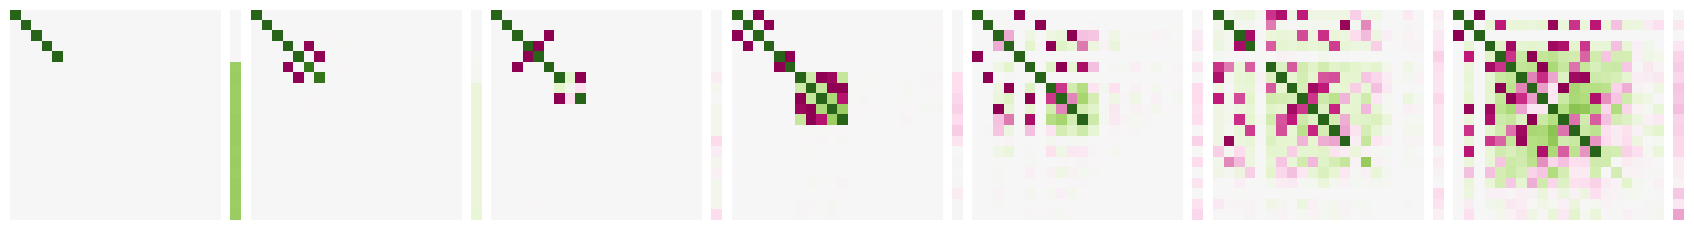

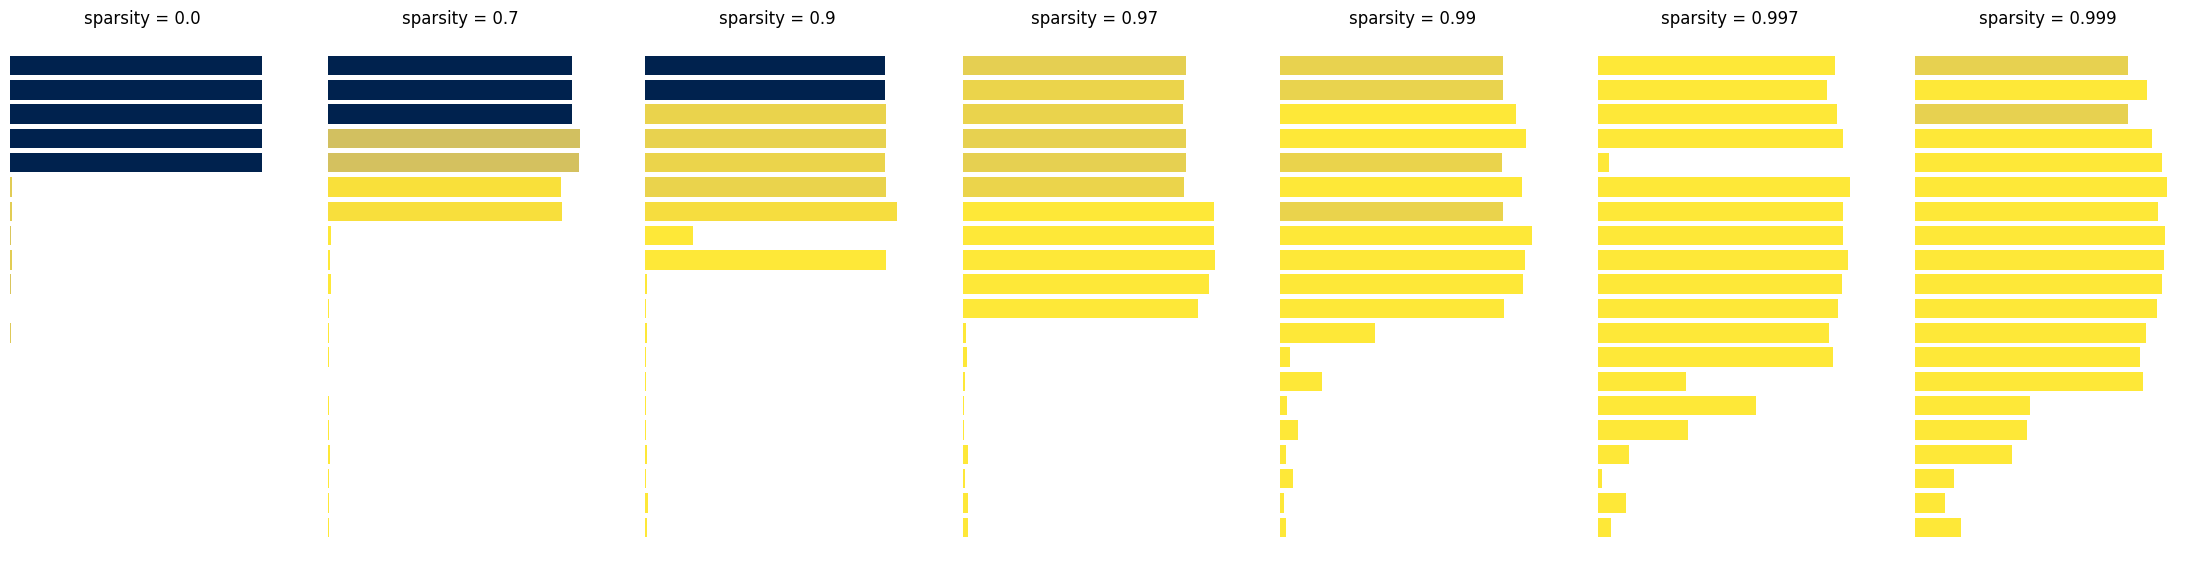

In [7]:

#  visualize all small models
fig = plt.figure(figsize=(21.6, 3))
grid = ImageGrid(fig, 111,  
                nrows_ncols=(1, 14),
                axes_pad=0.1
                )
plotpairs =[]
for sparsity in SPARSITIES:
    W,b = small_models[sparsity].weights.data, small_models[sparsity].bias.data
    plotpairs += [W.T @ W, b.reshape((len(b), 1))]
for ax, im in zip(grid, plotpairs):
    ax.set_axis_off()
    ax.imshow(im, origin="upper", vmin= -1, vmax= 1, cmap=mlp.colormaps['PiYG'])
    ax.set_label(f'Weight matrix and bias for sparsity {sparsity}')
plt.show()


fig = plt.figure(figsize=(28, 8))
for index in range(7):
    ax = plt.subplot(171 + index)
    W = small_models[SPARSITIES[index]].weights
    visualize_superposition(W, SPARSITIES[index], ax)

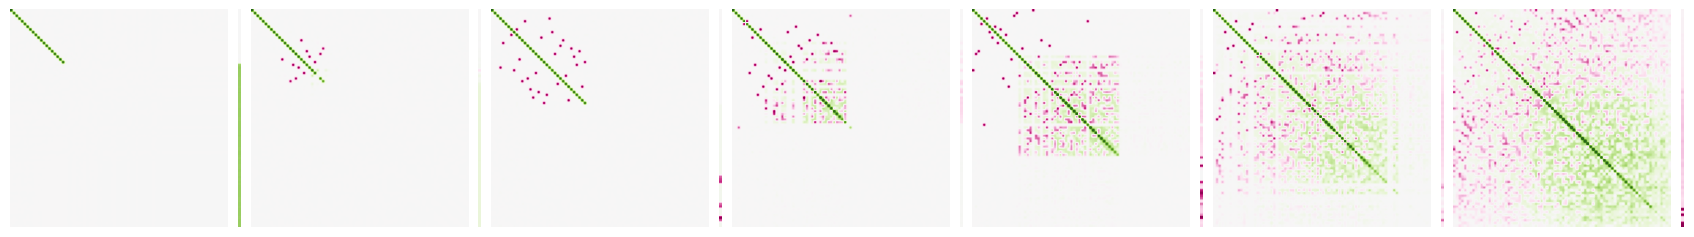

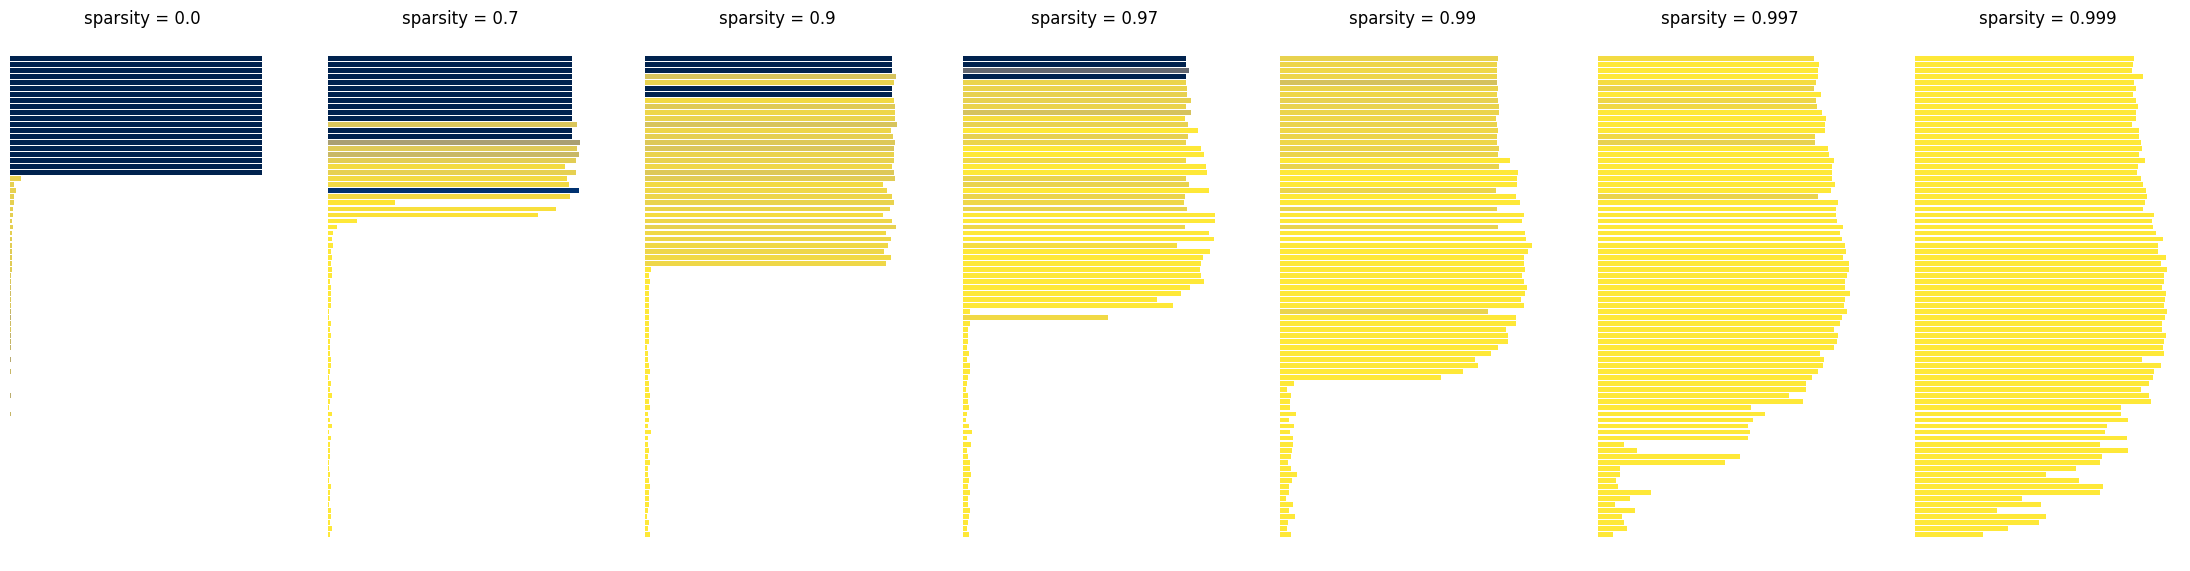

In [8]:
#visualize all large models
fig = plt.figure(figsize=(21.6, 3))
grid = ImageGrid(fig, 111,  
                nrows_ncols=(1, 14),
                axes_pad=0.1
                )
plotpairs =[]
for sparsity in SPARSITIES:
    W,b = big_models[sparsity].weights.data, big_models[sparsity].bias.data
    plotpairs += [W.T @ W, b.reshape((len(b), 1))]
for ax, im in zip(grid, plotpairs):
    ax.set_axis_off()
    ax.imshow(im, origin="upper", vmin= -1, vmax= 1, cmap=mlp.colormaps['PiYG'])
    ax.set_label(f'Weight matrix and bias for sparsity {sparsity}')
plt.show()

fig = plt.figure(figsize=(28, 8))
for index in range(7):
    ax = plt.subplot(171 + index)
    W = big_models[SPARSITIES[index]].weights
    visualize_superposition(W, SPARSITIES[index], ax)


Side remark on small differences that we observe if we compare the plots to those of the paper: 
- The representation of the less important features is not quite zero; this would probably disappear with further (more refined) training.
- The representation is >1 for some features with high superposition metric. This seems to be compensated by the bias vector, though I haven't checked. And it clearly looks different to the results presented in the paper.
- It is not necessarily the most important features that are not in superposition; probably an effect of random initialization of the weight matrix.
- Negative bias vectors of non-represented features. This seems to be a bug of the training here?
- The visualization of the sparsest regime for the big model looks quite different (from the results in the paper and the other models considered here). This case might need a customized training run. (The other cases also profit from customized training, but the chosen configuration seemed to work reasonably well for all of them.)